In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,4)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = 16

import dask.dataframe as dd
import pandas as pd
import numpy as np
import time
import warnings

import plotly.io as pio
pio.renderers.default = 'notebook'

# Table of Contents

## Load Data
- Load data from DeFiLlama

## Data Wrangling
- Resample hourly
- Replace daily with hourly data throughout

## Detect Triggers
- Set up ensenble of variable size confidence bands
- Build trigger objects
- Return trigger dates

## Graph Results
- Plot IPOR rate and rate spike signals
- Plot confidence interval plots and rate spike signals

# Load Data

## Load data from DeFiLlama

In [2]:
from dope.backengine.maestro import BackEngineMaestro
maestro = BackEngineMaestro()

In [3]:
pool_urls = """
#USDT
https://defillama.com/yields/pool/f981a304-bb6c-45b8-b0c5-fd2f515ad23a
https://defillama.com/yields/pool/4e8cc592-c8d5-4824-8155-128ba521e903
https://defillama.com/yields/pool/60d657c9-5f63-4771-a85b-2cf8d507ec00
https://defillama.com/yields/pool/c037a916-a462-4c65-b217-100db0fdc0e0
https://defillama.com/yields/pool/57647093-2868-4e65-97ab-9cae8ec74e7d
https://defillama.com/yields/pool/043a8330-bc29-4164-aa1c-28de7bf87755
https://defillama.com/yields/pool/4cecbdfa-7189-4801-88ef-cdfee4b23298
https://defillama.com/yields/pool/a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79
https://defillama.com/yields/pool/4ce0c458-2171-463b-92ce-458afe367a4e
https://defillama.com/yields/pool/edaefc40-d818-48bd-a87a-d9c87598c1bc
https://defillama.com/yields/pool/1350803f-262c-4c7e-b134-d2f693c7a7c8
https://defillama.com/yields/pool/c88d4008-f567-44e6-8ac8-a56d4f765a62
https://defillama.com/yields/pool/e43ddfa2-5e6b-40b2-ae74-d01e1a1c10b8
https://defillama.com/yields/pool/612af285-321a-4295-8362-59a6113da145
"""

pool_ids = [url.split("/")[-1] for url in pool_urls.split("\n") if "defillama.com" in url]

data, borrow_lend_data = maestro.load_defilama_with_token_pool_id(
  token_pool_id_dict = {  "USDT": pool_ids },
  start_period="2023-06-01"
)

USDT
Ethereum:aave-v3:USDT f981a304-bb6c-45b8-b0c5-fd2f515ad23a 482 482
Ethereum:fluid:USDT 4e8cc592-c8d5-4824-8155-128ba521e903 118 118
Ethereum:compound-v2:USDT 57647093-2868-4e65-97ab-9cae8ec74e7d 482 482
Ethereum:morpho-blue(LTV: 86%):WBTC-USDT c037a916-a462-4c65-b217-100db0fdc0e0 220 220
Ethereum:aave-v2:USDT 60d657c9-5f63-4771-a85b-2cf8d507ec00 480 480
Ethereum:morpho-blue(LTV: 86%):WSTETH-USDT 4ce0c458-2171-463b-92ce-458afe367a4e 220 220
Ethereum:morpho-blue(LTV: 100%):BBUSDT 043a8330-bc29-4164-aa1c-28de7bf87755 118 118
Ethereum:morpho-blue(LTV: 100%):GTUSDT 4cecbdfa-7189-4801-88ef-cdfee4b23298 118 118
Ethereum:morpho-blue(LTV: 91.5%):SUSDE-USDT a3a5cf89-9a9e-4db7-8f6d-1af3d5714d79 183 183
Ethereum:gearbox:USDT edaefc40-d818-48bd-a87a-d9c87598c1bc 174 174
Ethereum:morpho-blue(LTV: 100%):RE7USDT 1350803f-262c-4c7e-b134-d2f693c7a7c8 118 118
Ethereum:morpho-blue(LTV: 91.5%):USDE-USDT c88d4008-f567-44e6-8ac8-a56d4f765a62 179 179
Ethereum:morpho-blue(LTV: 86%):WSTETH-USDT e43ddfa2-5e

# Data Wrangling

## Resample hourly

In [4]:
from dope.backengine.maestro import BacktestData

enhanced_borrow_lend_data = {}
enhanced_borrow_lend_data_token = {}

warnings.filterwarnings("ignore")
for token in ['USDT']:
  enhanced_borrow_lend_data[token] = {}
  for mkt in borrow_lend_data[token].keys():
    enhanced_borrow_lend_data[token][mkt] = borrow_lend_data[token][mkt].resample("1h").last().interpolate()

  enhanced_borrow_lend_data_token[token] = BacktestData({token: enhanced_borrow_lend_data[token]})


enhanced_borrow_lend_data = BacktestData(enhanced_borrow_lend_data)
maestro.set_data(borrow_lend_data)

## Replace daily with hourly data throughout

In [5]:
borrow_lend_data = enhanced_borrow_lend_data
run_data = enhanced_borrow_lend_data

# Detect Triggers

## Set up ensemble of variable size confidence bands

In [6]:
ks = np.array([1.0, 1.5, 2.0, 3.0, 4.0, 5.0])

In [7]:
triggerObjs = {}
triggers = {}

## Build trigger objects

In [8]:
from dope.backengine.estimators.estimator import Estimator
from dope.backengine.estimators.clippedestimator import ClippedEstimator
from dope.backengine.triggers.confidencebandtrigger import ConfidenceBandTrigger

for token in ['USDT']:
  _data = pd.concat(borrow_lend_data[token], names=["datetime"]).unstack(level=0)
  triggerObjs[token] = {}
  triggers[token] = {}
  for k in ks:
    triggerObjs[token][k] = ConfidenceBandTrigger(_data, lag=0, lagSD=-7*24, est=Estimator(), rt_col='apyBase', k=k ) 
    
warnings.filterwarnings("default")    

## Return trigger dates

In [9]:
token = 'USDT'
for k in ks:
  triggers[token][k] = triggerObjs[token][k].dates() 

# Graph Results

In [10]:
def plot_rate_and_triggers(k):
  f, ax = plt.subplots(figsize=[17,10])
  df_graph = triggerObjs[token][k].rates().iloc[:,:12] #.dropna()
  from matplotlib.pyplot import cm
  import numpy as np
  color = iter(cm.viridis(np.append(np.linspace(0, 1.0, 13),np.linspace(0, 1.0, 13))))
  linestyles = ['-','-','-','-','-','-','-','-','-','-','-','-','-']

  for i in range(11,-1,-1):
     if df_graph.columns[i][1][:4] == 'cash':
         continue
     c = next(color) 
     l = df_graph.columns[i][1] # .split(":")
     ax.plot(df_graph.iloc[:,i], color=c, label=l, linestyle=linestyles[i])

  _ = plt.legend(loc='best',  fontsize=8)

  ax.set_xlim( min(df_graph.index), max(df_graph.index) )
  lims = ax.get_ylim()
  plt.vlines(x = triggers[token][k], ymin = lims[0], ymax = lims[1], colors = 'grey', label = 'Trigger dates', 
             alpha=0.125)

  scale=0.5; ax.set_ylim(scale*lims[0], scale*lims[1])
  #ax.set_xlim(pd.to_datetime('2024-03-15'), pd.to_datetime('2024-04-30'))
  plt.title(f"{token=}, {k=}")
  plt.show()

In [11]:
def plot_confidence_interval_and_triggers(k):
  f, ax = plt.subplots(figsize=[17,10])
  df_graph = triggerObjs[token][k].rates().iloc[:,24:] #.dropna()
  from matplotlib.pyplot import cm
  import numpy as np
  #color = iter(cm.rainbow(1-np.append(np.linspace(0, 0.25, 4),np.linspace(0.75, 1.0, 4))))
  color = iter(cm.viridis(np.append(np.linspace(0, 1.0, 13),np.linspace(0, 1.0, 13))))
  linestyles = ['--','--','--','--','--','--','--','--','--','--','--','--','--',
                '-','-','-','-','-','-','-','-','-','-','-','-','-']

  for i in range(23,-1,-1):
     if df_graph.columns[i][1][:4] == 'cash':
         continue
     c = next(color) 
     l = df_graph.columns[i][1] # .split(":")
     ax.plot(df_graph.iloc[:,i], color=c, label=l, linestyle=linestyles[i])

  _ = plt.legend(loc='best',  fontsize=8)

  ax.set_xlim( min(df_graph.index), max(df_graph.index) )
  lims = ax.get_ylim()
  plt.vlines(x = triggers[token][k], ymin = lims[0], ymax = lims[1], colors = 'grey', label = 'Trigger dates', 
             alpha=0.25)

  scale=1.0; ax.set_ylim(scale*lims[0], scale*lims[1])
  #ax.set_xlim(pd.to_datetime('2024-05-30'), pd.to_datetime('2024-06-15'))
  plt.title(f"{token=}, {k=}")
  plt.show()

## Plot IPOR rate and rate spike signals

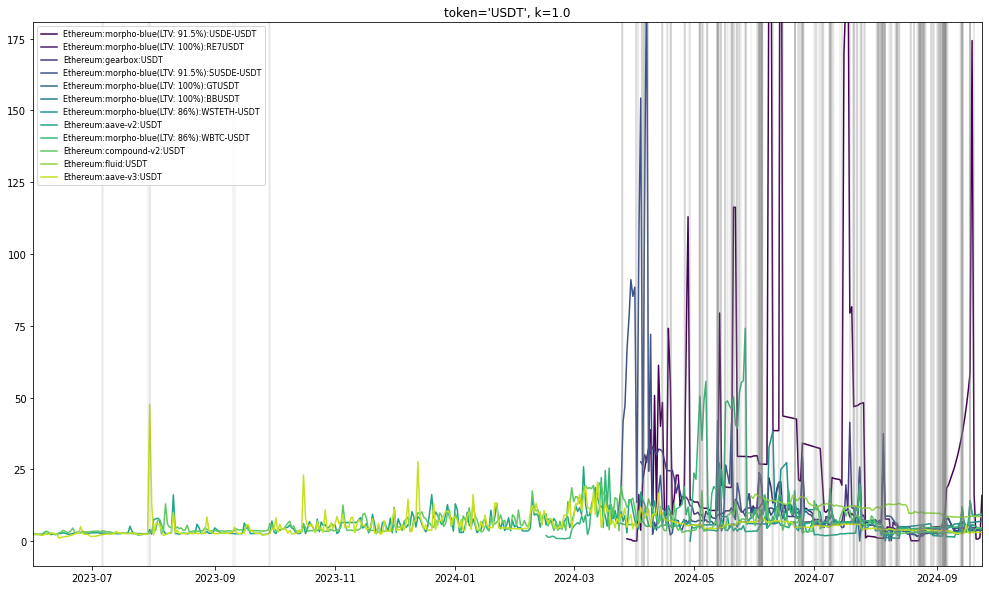

In [12]:
plot_rate_and_triggers(1.0)

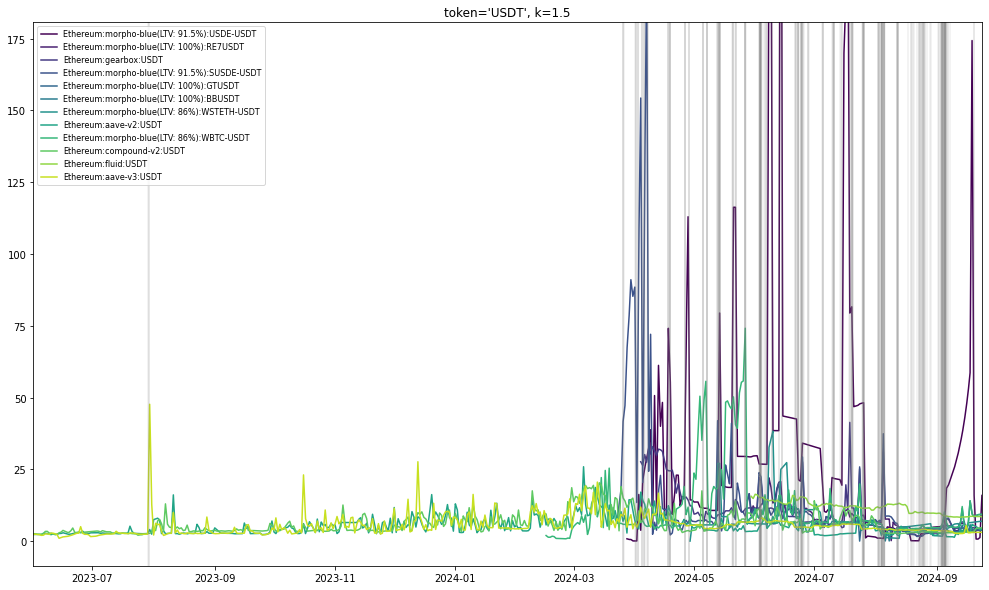

In [13]:
plot_rate_and_triggers(1.5)

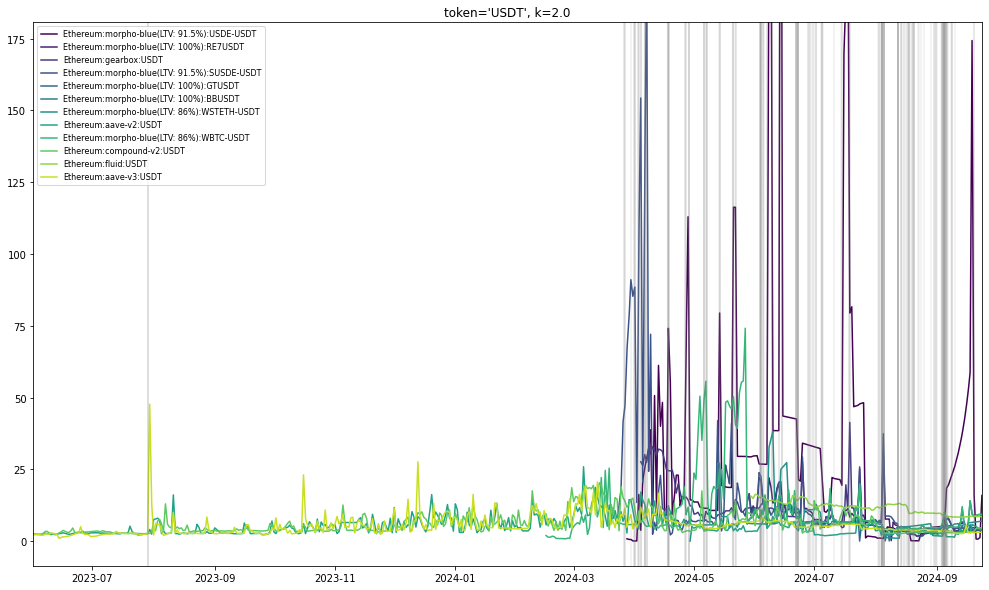

In [14]:
plot_rate_and_triggers(2.0)

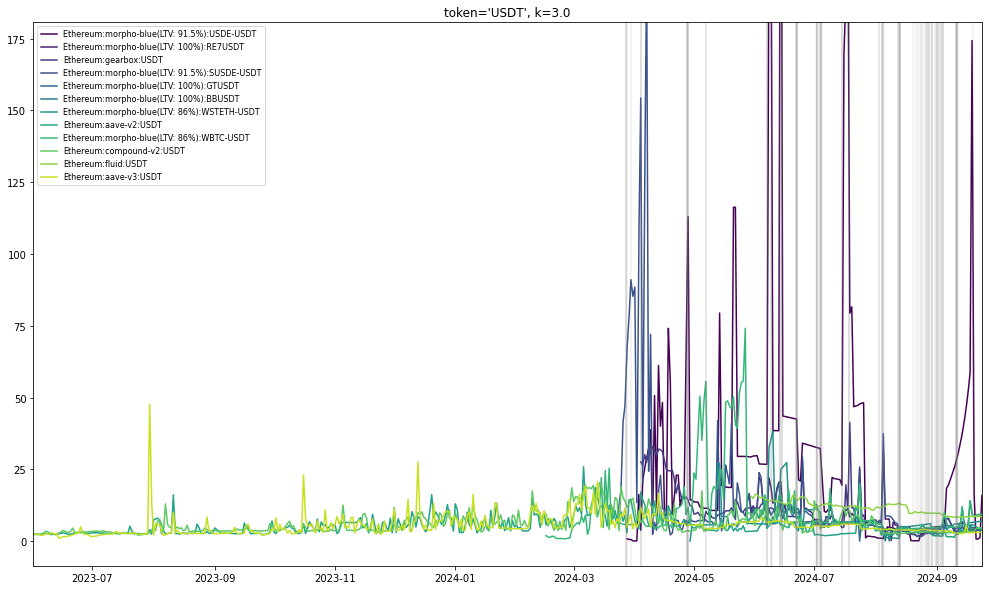

In [15]:
plot_rate_and_triggers(3.0)

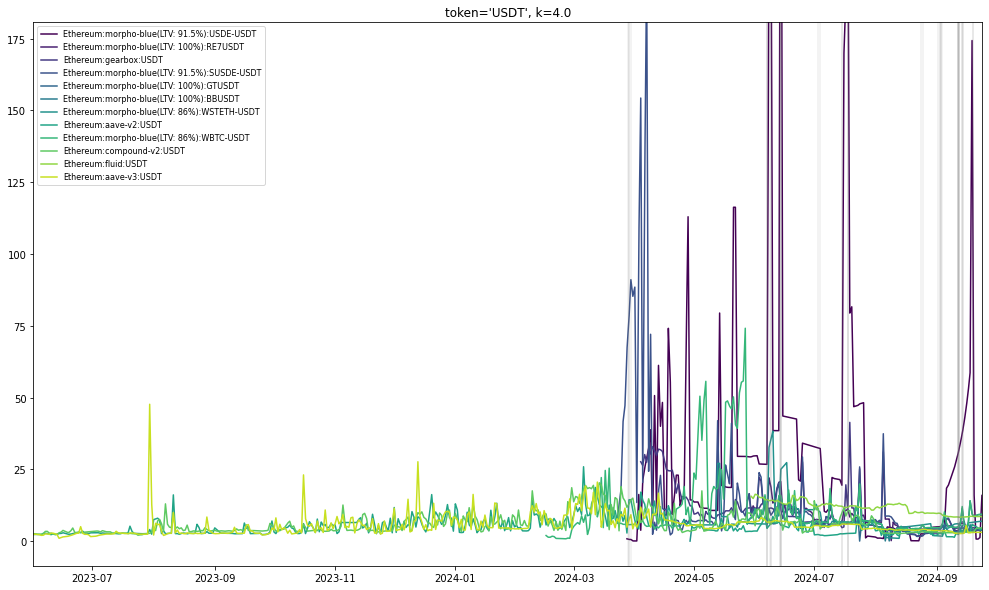

In [16]:
plot_rate_and_triggers(4.0)

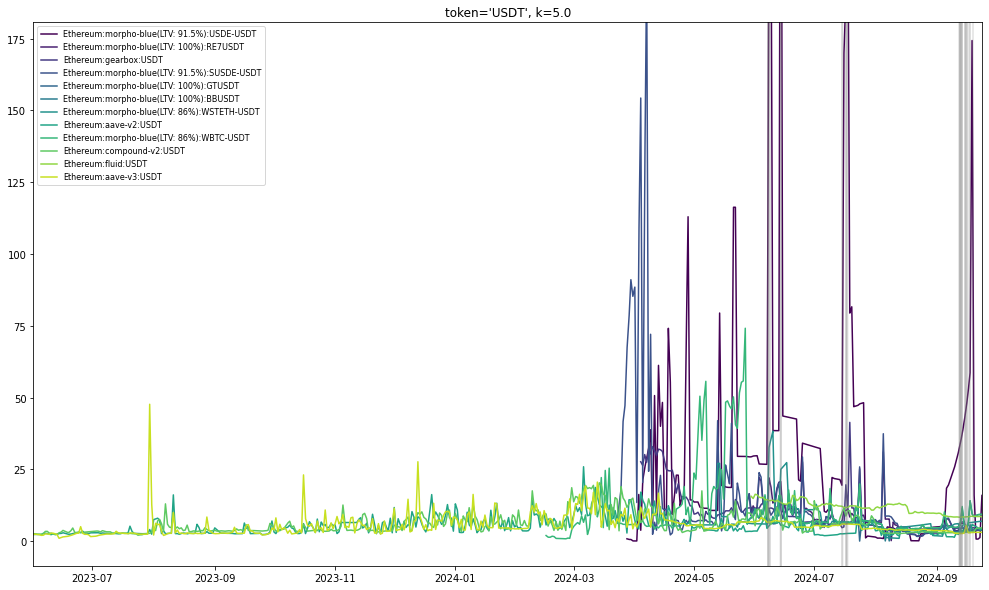

In [17]:
plot_rate_and_triggers(5.0)

## Plot confidence interval plots and rate spike signals

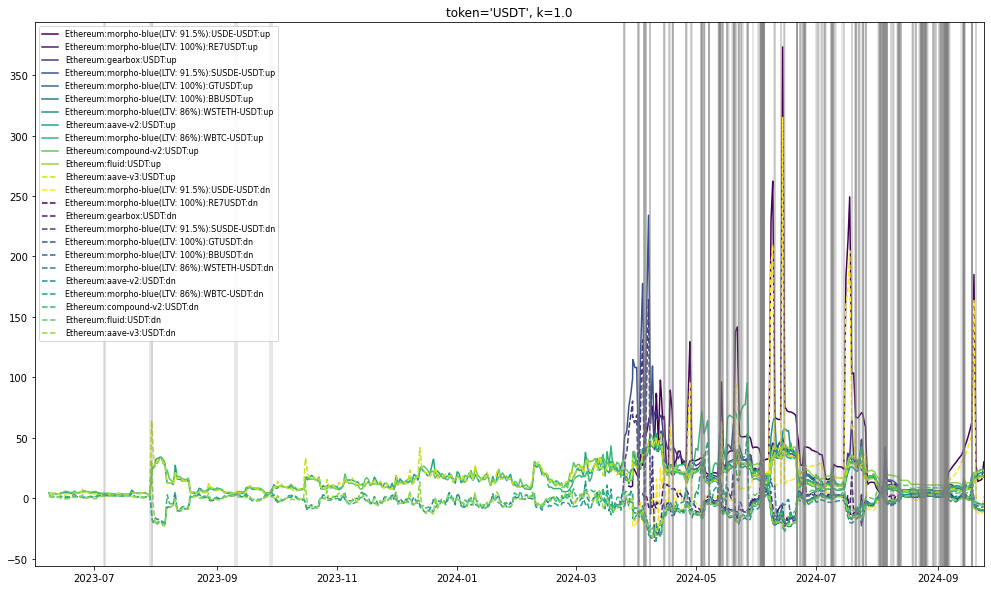

In [18]:
plot_confidence_interval_and_triggers(1.0)

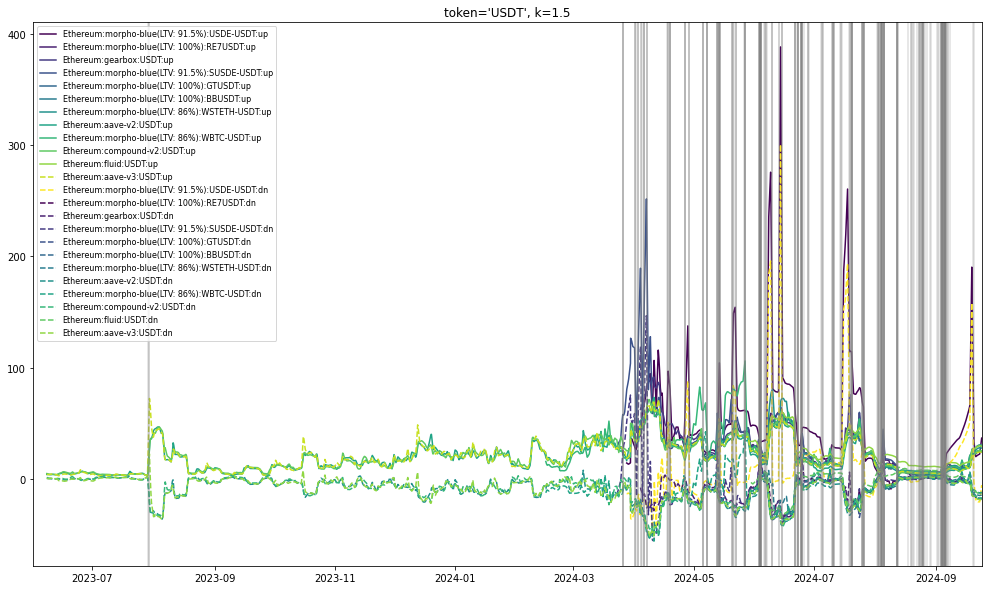

In [19]:
plot_confidence_interval_and_triggers(1.5)

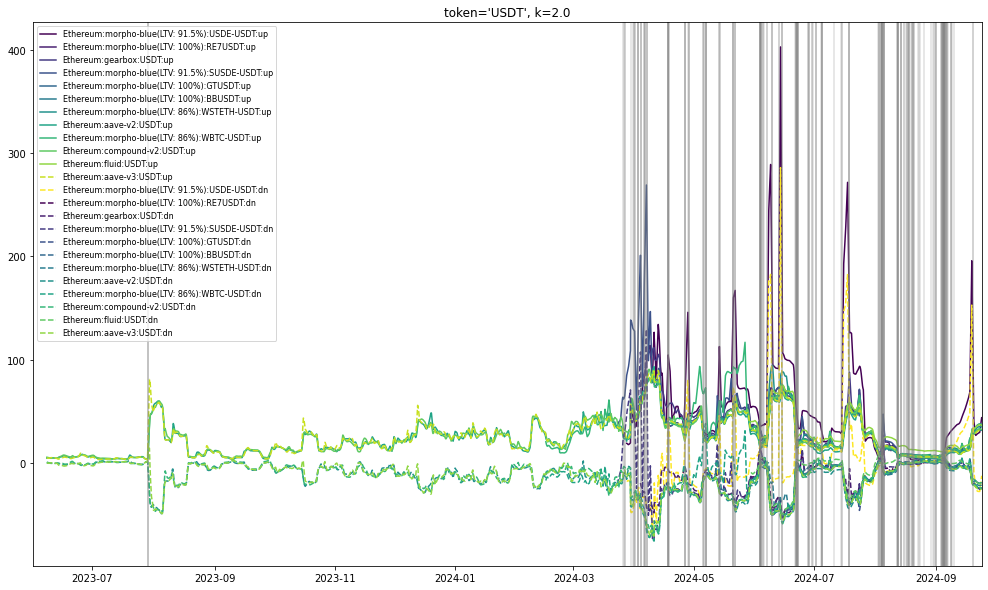

In [20]:
plot_confidence_interval_and_triggers(2.0)

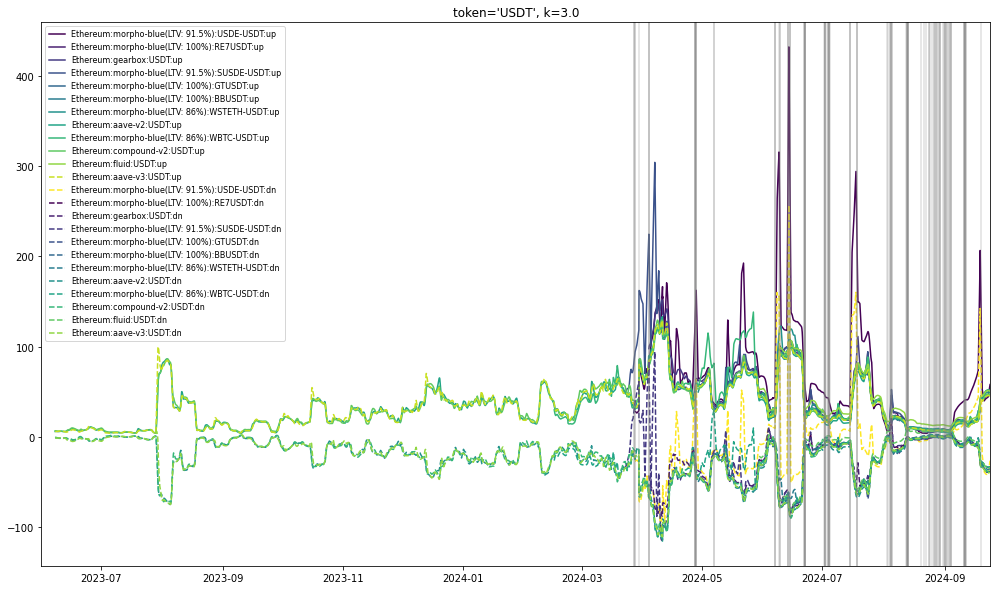

In [21]:
plot_confidence_interval_and_triggers(3.0)

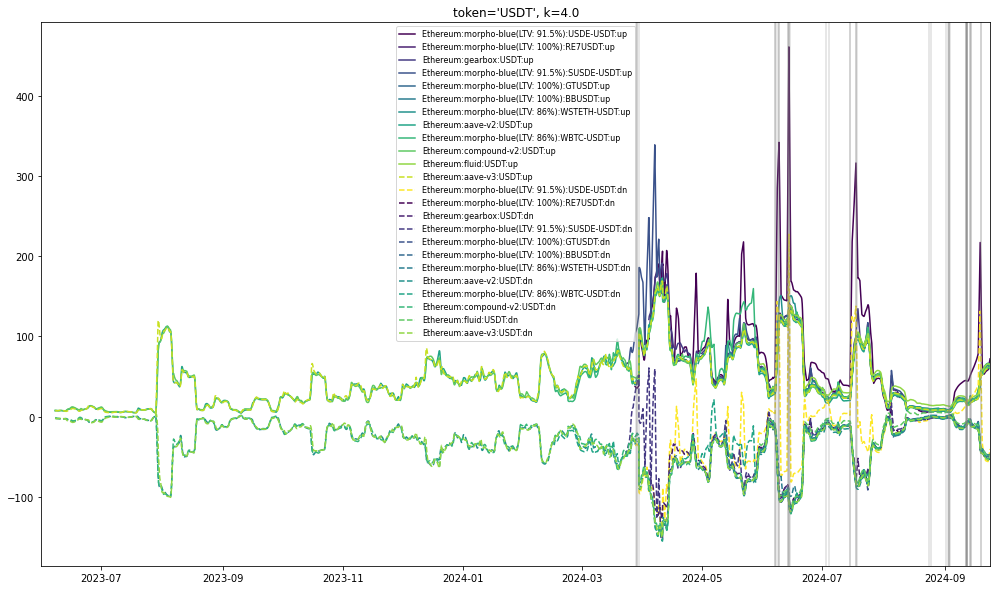

In [22]:
plot_confidence_interval_and_triggers(4.0)

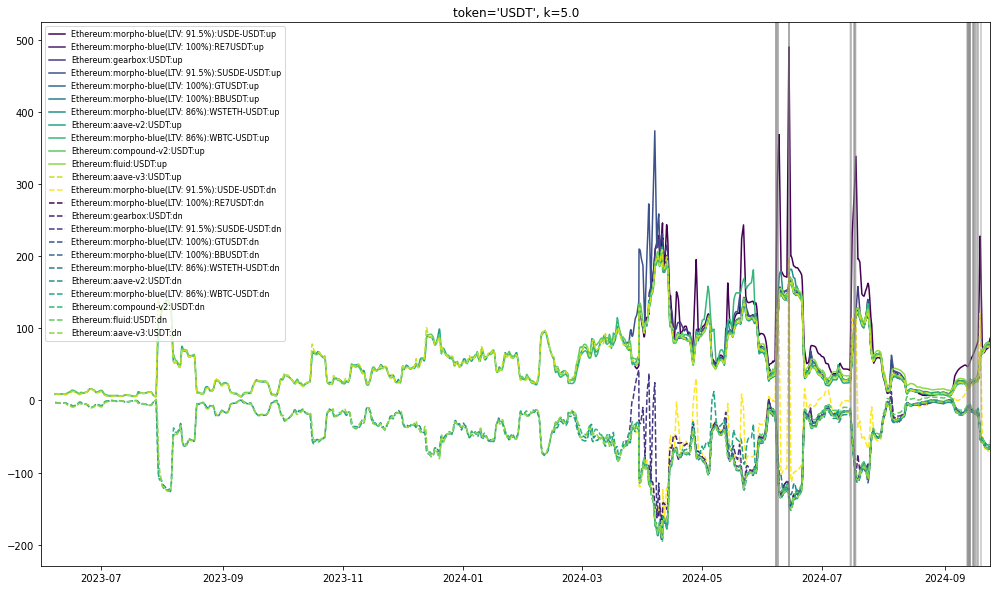

In [23]:
plot_confidence_interval_and_triggers(5.0)